# Sample file to generate partition on an articles using Community Detection
* Input - article text
* Output - partition assignment
* author: harin

In [1]:
import pandas as pd
import numpy as np
import spacy

In [2]:
file = open('../data/raw/2018_07_19_04_59_08/articles.txt', 'r', encoding = 'utf8')

In [3]:
articles_dt = file.read().split('\n')[:-1]
pubId, canonicalUrl,firstScrape,title,text = [],[],[],[],[]

for article in articles_dt:    
    row = article.split('\t')
    pubId.append(row[0])
    canonicalUrl.append(row[4])
    firstScrape.append(row[5])
    title.append(row[8])
    text.append(row[9])

articles_df = pd.DataFrame()
articles_df['pubId'] = pubId
articles_df['canonicalUrl'] = canonicalUrl
articles_df['firstScrape'] = firstScrape
articles_df['title'] = title
articles_df['text'] = text

In [4]:
articles_df.shape

(213605, 5)

In [5]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity

nlp = spacy.load("en_core_web_sm")
sample_df = articles_df.sample(n=1000)
docs = list(nlp.pipe(sample_df.text))
embs = [doc.vector for doc in docs]

embs_df = pd.DataFrame(embs)
embs_df = embs_df.dropna()
cs = cosine_similarity(embs_df)

# Construct graph

In [6]:
cs

array([[1.        , 0.9205256 , 0.97829848, ..., 0.92528466, 0.88951605,
        0.96652196],
       [0.9205256 , 1.        , 0.90560384, ..., 0.86224343, 0.81264908,
        0.94881568],
       [0.97829848, 0.90560384, 1.        , ..., 0.91579722, 0.86884357,
        0.9542964 ],
       ...,
       [0.92528466, 0.86224343, 0.91579722, ..., 1.        , 0.92716824,
        0.89357176],
       [0.88951605, 0.81264908, 0.86884357, ..., 0.92716824, 1.        ,
        0.84669622],
       [0.96652196, 0.94881568, 0.9542964 , ..., 0.89357176, 0.84669622,
        1.        ]])

In [7]:
import networkx as nx
import community
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
G = nx.Graph()

In [9]:
threshold = 0.5

In [10]:
G.add_edge(1, 2)

In [11]:
for i in range(len(cs)):
    similarities = cs[i]
    for j, sim in enumerate(similarities):
        if i == j: continue
        if sim > threshold:
            G.add_edge(i, j)

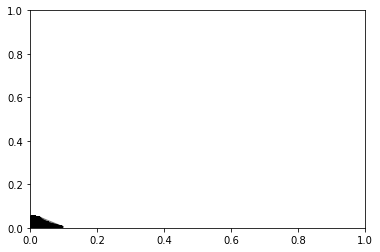

In [12]:
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.5)

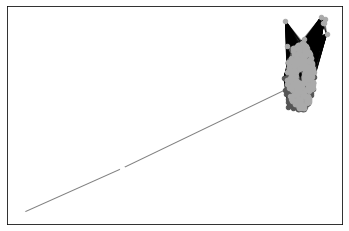

In [13]:
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [14]:
num_cluster = max([v for k,v in partition.items()]) + 1

In [15]:
num_cluster

3

# Evaluate

[-1 -1 -1 -1 -1 0 1] -> cluster of -1 -> acc = 5/7

[0 0 0 -1 1 -1 1] -> clusters of 0 -> acc = 3/7

In [24]:
import os


In [31]:
rootdir = '../data/labels'

for subdir, dir_, file in os.walk(rootdir):
    if(subdir.count("/") == 3):
        print(subdir + "/lower_bound.txt")

../data/labels/duckboat/lower_bound.txt
../data/labels/cave_rescue/lower_bound.txt
../data/labels/helsinki_summit/lower_bound.txt


In [16]:
label0_file = open('../data/labels/cave_rescue/population.txt', 'r', encoding = 'utf8')
label0 = label0_file.read().split('\n')
label1_file = open('../data/labels/duckboat/lower_bound.txt', 'r', encoding = 'utf8')
label1 = label1_file.read().split('\n')
label2_file = open('../data/labels/helsinki_summit/lower_bound.txt', 'r', encoding = 'utf8')
label2 = label2_file.read().split('\n')

In [17]:
urls = list( articles_df['canonicalUrl'])

In [18]:
labels = {}
for idx, url in enumerate(urls):
    if url in label0:
        labels[idx] = 0
    elif url in label1:
        labels[idx] = 1
    elif url in label2:
        labels[idx] = 2
    else: labels[idx] = -1

In [19]:
# [label for label in labels if label > -1]

In [20]:
len(label0)

711

In [32]:
cluster0 = [k for k,v in partition.items() if v == 0]
cluster1 = [k for k,v in partition.items() if v == 1]

In [68]:
cluster0_labels = [labels[i] for i in cluster0]# if labels[i] != -1]
cluster1_labels = [labels[i] for i in cluster1]# if labels[i] != -1]

In [37]:
pred0 = [max(cluster0_labels,key=cluster1_labels.count)]*len(cluster0)
pred1 = [max(cluster1_labels,key=cluster1_labels.count)]*len(cluster1)

In [54]:
from sklearn.metrics import confusion_matrix
y_true = cluster0_labels + cluster1_labels
y_pred = pred0 + pred1


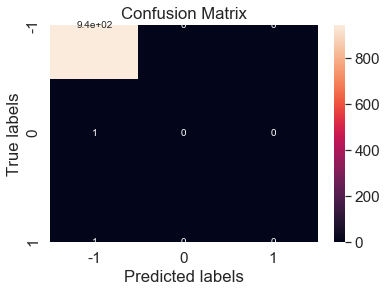

In [49]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(y_true, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([-1, 0, 1]); ax.yaxis.set_ticklabels([-1, 0, 1]);

In [53]:
acc = np.trace(cm)/np.sum(cm)
print("Accuracy: ", acc)

Accuracy:  0.9978835978835979


In [55]:
print(cm)

[[943   0   0]
 [  1   0   0]
 [  1   0   0]]


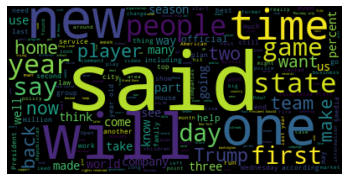

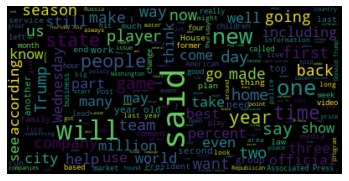

In [69]:
from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = ""
for t in sample_df['text'].reset_index(drop = True)[cluster0]:
    text += t

def do_wordcloud(txt):
    # Generate a word cloud image
    stopwords = set(STOPWORDS)
    stopwords.add("int")
    stopwords.add("ext")

    wordcloud = WordCloud(stopwords=stopwords).generate(txt)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    # The pil way (if you don't have matplotlib)
    # image = wordcloud.to_image()
    # image.show()
do_wordcloud(text)

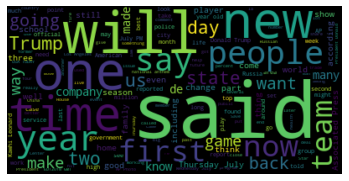

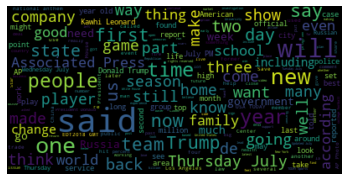

In [70]:
text = ""
for t in sample_df['text'].reset_index(drop = True)[cluster1]:
    text += t
do_wordcloud(text)